C:\Users\boorl\anaconda3\envs\convAE\lib\site-packages\keras_preprocessing\image\affine_transformations.py:13: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.6)
  import scipy


Epoch 1/150
3/3 [==============================] - 27s 827ms/step - loss: 0.1183 - val_loss: 0.0928
Epoch 2/150
3/3 [==============================] - 0s 162ms/step - loss: 0.1005 - val_loss: 0.0658
Epoch 3/150
3/3 [==============================] - 0s 187ms/step - loss: 0.0649 - val_loss: 0.0338
Epoch 4/150
3/3 [==============================] - 0s 172ms/step - loss: 0.0512 - val_loss: 0.0233
Epoch 5/150
3/3 [==============================] - 0s 97ms/step - loss: 0.0492 - val_loss: 0.0214
Epoch 6/150
3/3 [==============================] - 0s 108ms/step - loss: 0.0427 - val_loss: 0.0259
Epoch 7/150
3/3 [==============================] - 0s 137ms/step - loss: 0.0421 - val_loss: 0.0238
Epoch 8/150
3/3 [==============================] - 0s 163ms/step - loss: 0.0396 - val_loss: 0.0287
Epoch 9/150
3/3 [==============================] - 0s 166ms/step - loss: 0.0378 - val_loss: 0.0190
Epoch 10/150
3/3 [==============================] - 0s 110ms/step - loss: 0.0377 - val_loss: 0.0214
Epoch 11/

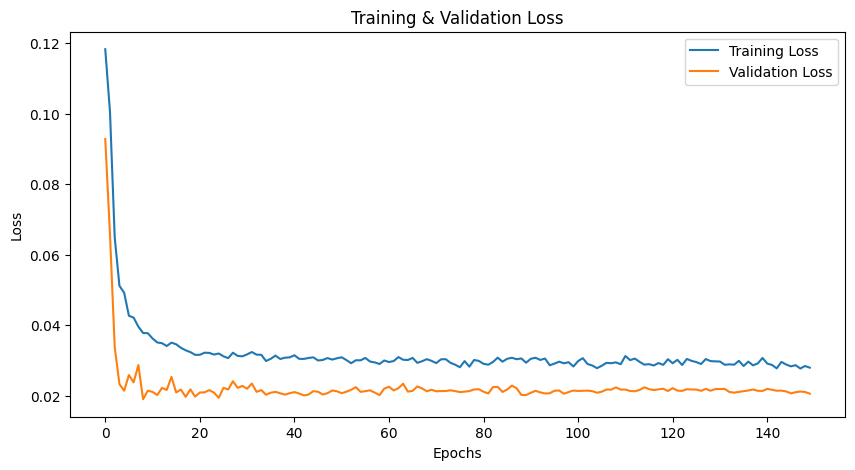

C:\Users\boorl\anaconda3\envs\convAE\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 9989 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\boorl\anaconda3\envs\convAE\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 10060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\boorl\anaconda3\envs\convAE\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 9989 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\boorl\anaconda3\envs\convAE\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 10060 missing from current font.
  font.set_text(s, 0, flags=flags)


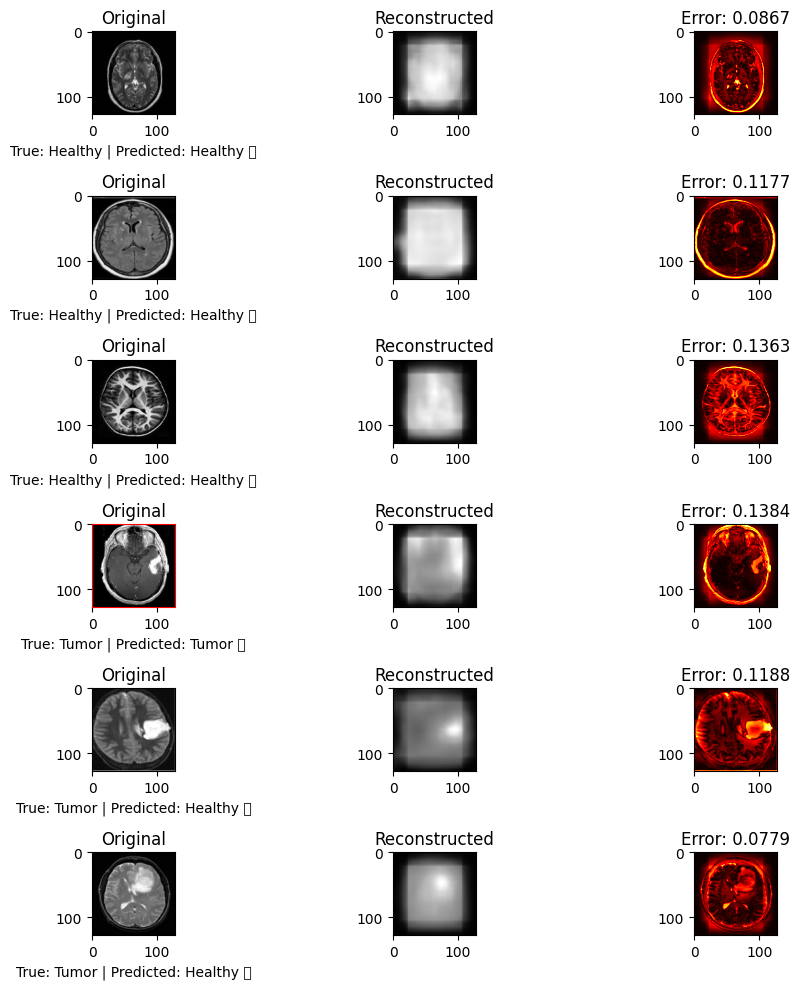

Image: C:/Users/boorl/anaconda3/envs/convAE/brain_tumor_dataset\no\35 no.jpg | True: Healthy | Predicted: Healthy ✅ | Error: 0.0867
Image: C:/Users/boorl/anaconda3/envs/convAE/brain_tumor_dataset\no\31 no.jpg | True: Healthy | Predicted: Healthy ✅ | Error: 0.1177
Image: C:/Users/boorl/anaconda3/envs/convAE/brain_tumor_dataset\no\14 no.jpg | True: Healthy | Predicted: Healthy ✅ | Error: 0.1363
Image: C:/Users/boorl/anaconda3/envs/convAE/brain_tumor_dataset\yes\Y55.jpg | True: Tumor | Predicted: Tumor ✅ | Error: 0.1384
Image: C:/Users/boorl/anaconda3/envs/convAE/brain_tumor_dataset\yes\Y97.JPG | True: Tumor | Predicted: Healthy ❌ | Error: 0.1188
Image: C:/Users/boorl/anaconda3/envs/convAE/brain_tumor_dataset\yes\Y66.JPG | True: Tumor | Predicted: Healthy ❌ | Error: 0.0779


In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# **Step 1: Load Dataset (Only Healthy Images for Training)**
data_dir = "C:/Users/boorl/anaconda3/envs/convAE/brain_tumor_dataset"  # Update path
img_size = 128

healthy_data = []
for img_name in os.listdir(os.path.join(data_dir, "no")):
    try:
        img_path = os.path.join(data_dir, "no", img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))
        healthy_data.append(img)
    except Exception as e:
        print(f"Error loading image: {img_name} - {e}")

healthy_data = np.array(healthy_data) / 255.0
healthy_data = np.expand_dims(healthy_data, axis=-1)

# Train-test split
X_train, X_val = train_test_split(healthy_data, test_size=0.2, random_state=42)

# **Step 2: Data Augmentation**
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# **Step 3: Autoencoder Model**
input_img = Input(shape=(img_size, img_size, 1))

# Encoder
x = Conv2D(64, (3, 3), activation="relu", padding="same")(input_img)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
encoded = MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = Conv2D(128, (3, 3), activation="relu", padding="same")(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer="adam", loss="mse")

# **Step 4: Train Autoencoder**
history = autoencoder.fit(
    datagen.flow(X_train, X_train, batch_size=32),
    epochs=150,  # Increased to 150
    batch_size=32,
    validation_data=(X_val, X_val)
)

# **Step 5: Plot Accuracy Graphs**
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.show(block=True) 

# **Step 6: Compute Reconstruction Error**
def compute_reconstruction_error(model, images):
    reconstructed = model.predict(images)
    errors = np.mean(np.abs(images - reconstructed), axis=(1, 2, 3))
    return reconstructed, errors

# **Step 7: Validate on Random Images from Yes & No Categories**
test_images, test_labels, test_paths = [], [], []

for category in ["no", "yes"]:
    path = os.path.join(data_dir, category)
    for img_name in np.random.choice(os.listdir(path), 3, replace=False):  # Random 3 images
        try:
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            test_images.append(img)
            test_labels.append(0 if category == "no" else 1)  # 0: Healthy, 1: Tumor
            test_paths.append(img_path)
        except:
            continue

test_images = np.array(test_images) / 255.0
test_images = np.expand_dims(test_images, axis=-1)

# **Step 8: Compute Reconstruction Error**
reconstructed_images, errors = compute_reconstruction_error(autoencoder, test_images)
threshold = np.percentile(errors, 90)  # 90th percentile threshold

# **Step 9: Display Results**
fig, axes = plt.subplots(len(test_images), 3, figsize=(10, 10))

for i in range(len(test_images)):
    axes[i, 0].imshow(test_images[i].squeeze(), cmap="gray")
    axes[i, 0].set_title("Original")

    axes[i, 1].imshow(reconstructed_images[i].squeeze(), cmap="gray")
    axes[i, 1].set_title("Reconstructed")

    axes[i, 2].imshow(np.abs(test_images[i] - reconstructed_images[i]).squeeze(), cmap="hot")
    axes[i, 2].set_title(f"Error: {errors[i]:.4f}")

    # **Tumor Detection Logic**
    detected_label = "Tumor" if errors[i] > threshold else "Healthy"
    true_label = "Tumor" if test_labels[i] == 1 else "Healthy"
    correct = "✅" if detected_label == true_label else "❌"

    # Display Labels
    axes[i, 0].set_xlabel(f"True: {true_label} | Predicted: {detected_label} {correct}")
    
    # Highlight Tumor if detected
    if detected_label == "Tumor":
        axes[i, 0].spines["bottom"].set_color("red")
        axes[i, 0].spines["top"].set_color("red")
        axes[i, 0].spines["left"].set_color("red")
        axes[i, 0].spines["right"].set_color("red")

plt.tight_layout()
plt.show()

# **Step 10: Print Errors & Detection Results**
for i in range(len(test_images)):
    detected_label = "Tumor" if errors[i] > threshold else "Healthy"
    true_label = "Tumor" if test_labels[i] == 1 else "Healthy"
    correct = "✅" if detected_label == true_label else "❌"
    print(f"Image: {test_paths[i]} | True: {true_label} | Predicted: {detected_label} {correct} | Error: {errors[i]:.4f}")
